#Project 14 - Intro. to Deep Reinforcement Learning - Wilfredo Aaron Sosa Ramos

Sources:
* https://rail.eecs.berkeley.edu/deeprlcourse-fa18/
* https://web.stanford.edu/class/cs234/index.html

#Reinforcement Learning

Markov Decision Processes (MDPs):



*   Integration with MNIST: MNIST can be seen as an environment where each image is a state, and the agent (RL model) takes actions to classify digits.
*   Pipelines and Data Scalability: Implement a data preprocessing pipeline using tools like scikit-learn's Pipeline to scale features or perform other transformations.
*   TensorFlow Integration: Train an RL agent using TensorFlow's reinforcement learning APIs, defining states, actions, rewards, and transitions.


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense

Load MNIST dataset

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


Visualize sample MNIST images

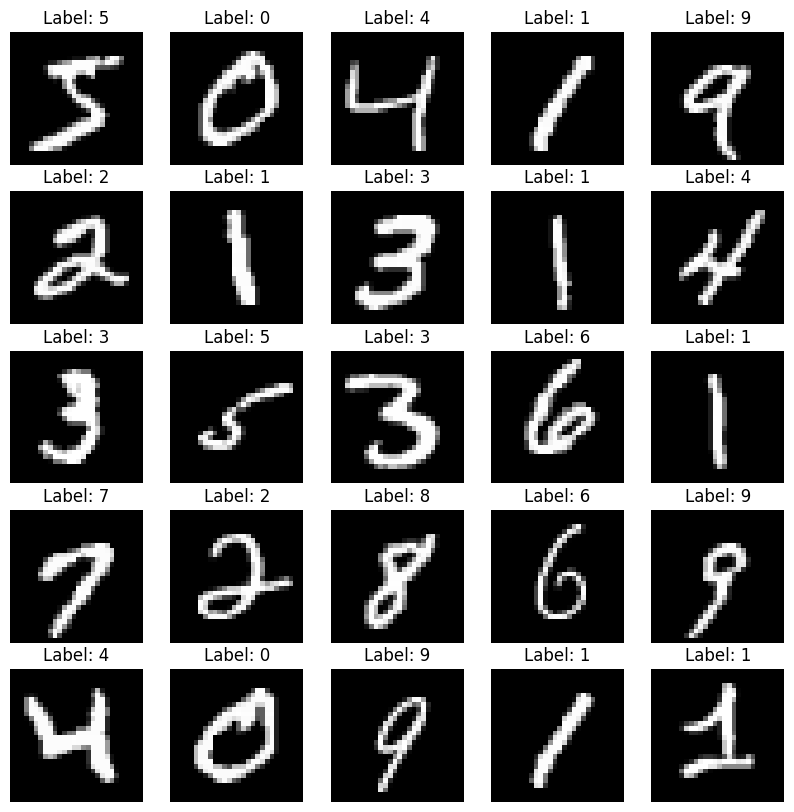

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

In [ ]:
# Reshape images and normalize pixel values

# Reshape images from 28x28 to a flat array of size 784
x_train = x_train.reshape((-1, 28*28))  # Reshape training images
x_test = x_test.reshape((-1, 28*28))    # Reshape testing images

# Convert pixel values to floating point numbers and normalize them between 0 and 1
# Pixel values in MNIST dataset range from 0 to 255 (grayscale)
x_train = x_train.astype('float32') / 255.0  # Normalize training images
x_test = x_test.astype('float32') / 255.0    # Normalize testing images

#Markov Decision Processes

Markov Decision Processes (MDPs) are mathematical frameworks used to model sequential decision-making problems in situations where outcomes are partially random and partially under the control of a decision maker, or agent.

#Components of an MDP:


*   States (S): MDPs involve a set of possible states that the system can be in. These states represent different configurations or situations the system can inhabit. In the context of RL, states can represent various aspects of the environment that are relevant to decision making.
*   Actions (A): At each state, the decision maker (agent) can choose from a set of possible actions. Actions represent the choices or decisions the agent can make to influence the future state of the system. The actions available to the agent may vary depending on the current state.
*   Transition Probabilities (P): MDPs incorporate transition probabilities that describe the likelihood of transitioning from one state to another after taking a particular action. These probabilities capture the stochastic nature of the environment, indicating the uncertainty in the system dynamics.
*   Rewards (R): At each state, and after taking a specific action, the agent receives a numerical reward. Rewards quantify the desirability or utility of being in a particular state and taking a specific action. The goal of the agent is to maximize the cumulative reward it receives over time.
*   Discount Factor (γ): MDPs often include a discount factor (γ), which is a value between 0 and 1. This factor determines the importance of future rewards relative to immediate rewards. A discount factor closer to 1 implies that the agent values future rewards more, while a discount factor closer to 0 gives more weight to immediate rewards.











#Dynamics of an MDP:

*   Policy (π): A policy defines the agent's strategy or behavior in the MDP. It maps states to actions, indicating what action the agent should take in each state. Policies can be deterministic (mapping states to specific actions) or stochastic (assigning probabilities to actions).
*   Value Functions: Value functions estimate the expected return, or cumulative reward, that the agent can achieve from a particular state or state-action pair under a given policy. The value functions help the agent assess the desirability of different states or actions and guide its decision-making process.


# Goal of an MDP:
The primary objective in an MDP is to find an optimal policy that maximizes the expected cumulative reward over time. The optimal policy determines the best action to take in each state, leading to the highest possible long-term reward.

#MNIST Dataset:

States (S): Each state represents a grayscale image of a handwritten digit.

Actions (A): Actions correspond to the digits (0-9) predicted by the agent for each image.

Transition Probabilities (P): Since MNIST is a static dataset, transitions between states (images) are deterministic after an action (prediction) is made.

Rewards (R): Rewards are received based on the accuracy of the agent's prediction for each image, typically 1 for correct predictions and 0 for incorrect ones.

Discount Factor (γ): May not play a significant role in the episodic task of digit classification, as there are no future states beyond the current prediction.

Policy (π): The policy maps images to predicted digits, defining the agent's strategy for classification.

Value Functions: Estimate the expected accuracy or utility of predicting a digit for a given image under a given policy.

Goal of an MDP: To find an optimal policy that maximizes prediction accuracy across all images, determining the best action (predicted digit) for each image.

In [ ]:
# Define MDP environment

class MNISTEnvironment:
    def __init__(self, x, y):
        """
        Initialize the MNIST environment.

        Args:
            x (numpy.ndarray): Input images.
            y (numpy.ndarray): Corresponding labels.
        """
        self.x = x  # Input images
        self.y = y  # Corresponding labels
        self.num_states = x.shape[0]  # Number of states (images)
        self.num_actions = 10  # Number of actions (0-9 digits)
        self.current_state_idx = 0  # Initialize state index

    def reset(self):
        """
        Reset the environment to the initial state.

        Returns:
            numpy.ndarray: Initial state (image).
        """
        self.current_state_idx = 0  # Reset state index to start
        return self.x[self.current_state_idx]  # Return initial state (image)

    def step(self, action):
        """
        Take an action in the environment.

        Args:
            action (int): The action to take.

        Returns:
            tuple: Tuple containing:
                - numpy.ndarray: Next state (image).
                - float: Reward obtained from the action.
                - bool: Whether the episode is done.
        """
        done = False  # Initialize done flag
        reward = 0  # Initialize reward
        # Check if action matches the true label
        if action == self.y[self.current_state_idx]:
            reward = 1  # Assign reward of 1 for correct classification
        self.current_state_idx += 1  # Move to the next state (image)
        if self.current_state_idx >= self.num_states-1:
            done = True  # Mark episode as done if all states are visited
            next_state = None # Set next_state to None when episode terminates
        next_state = self.x[self.current_state_idx]  # Get the next state (image)
        return next_state, reward, done  # Return next state, reward, and done flag


#QLearningAgent:

A QLearningAgent is an implementation of an agent in reinforcement learning that utilizes the Q-learning algorithm. Q-learning is a model-free reinforcement learning technique used to find the optimal action-selection policy for a given Markov Decision Process (MDP).

1.   Initialization: The QLearningAgent class is initialized with parameters such as the number of possible actions (num_actions), learning rate (learning_rate), discount factor (discount_factor), and exploration rate (epsilon).
2.   Choose Action: The choose_action method implements an exploration-exploitation strategy, typically epsilon-greedy. It selects an action based on the current state and the agent's learned Q-values. With probability epsilon, the agent explores by choosing a random action, and with probability 1 - epsilon, it exploits by selecting the action with the highest Q-value.
3.  Update Q-values: The update_q_values method updates the Q-values based on the observed transition. It takes as input the current state, the action taken, the reward received, and the next state. Using the Q-learning update rule, it calculates the target Q-value and updates the Q-value for the chosen action.
4.  Q-values: The Q-values represent the expected cumulative reward the agent can achieve by taking specific actions in specific states. These values are stored in a table or a function approximator and are updated iteratively as the agent interacts with the environment.


In [ ]:
# Define RL agent

class QLearningAgent:
    def __init__(self, num_actions, learning_rate=0.1, discount_factor=0.99, epsilon=0.1):
        """
        Initialize the Q-Learning agent.

        Args:
            num_actions (int): Number of possible actions.
            learning_rate (float): Learning rate for updating Q-values.
            discount_factor (float): Discount factor for future rewards.
            epsilon (float): Probability of selecting a random action (exploration).
        """
        self.num_actions = num_actions  # Number of possible actions
        self.learning_rate = learning_rate  # Learning rate for Q-value updates
        self.discount_factor = discount_factor  # Discount factor for future rewards
        self.epsilon = epsilon  # Probability of exploration
        self.q_values = np.zeros((num_actions,))  # Initialize Q-values for each action

    def choose_action(self, state):
        """
        Choose an action based on the epsilon-greedy policy.

        Args:
            state (numpy.ndarray): Current state representation.

        Returns:
            int: Selected action.
        """
        # Epsilon-greedy policy
        if np.random.rand() < self.epsilon:  # With probability epsilon, explore randomly
            return np.random.randint(self.num_actions)  # Random action
        else:  # With probability 1 - epsilon, exploit the best action based on Q-values
            return np.argmax(self.q_values)  # Best action based on current Q-values

    def update_q_values(self, state, action, reward, next_state):
        """
        Update Q-values based on the observed transition.

        Args:
            state (numpy.ndarray): Current state representation.
            action (int): Action taken in the current state.
            reward (float): Reward received after taking the action.
            next_state (numpy.ndarray): Next state representation.
        """
        # Calculate the target value using Q-Learning update rule
        best_next_action = np.argmax(self.q_values)  # Select the best action for the next state
        td_target = reward + self.discount_factor * self.q_values[best_next_action]  # Compute target Q-value
        td_error = td_target - self.q_values[action]  # Compute TD error
        # Update Q-value for the chosen action
        self.q_values[action] += self.learning_rate * td_error  # Update Q-value based on TD error and learning rate


Define preprocessing pipeline

In [ ]:
preprocessing_pipeline = Pipeline([
    ('scaling', StandardScaler())
])

Preprocess training and testing data

In [ ]:
x_train_preprocessed = preprocessing_pipeline.fit_transform(x_train)
x_test_preprocessed = preprocessing_pipeline.transform(x_test)

Initialize environment and agent

In [ ]:
env = MNISTEnvironment(x_train_preprocessed, y_train)
agent = QLearningAgent(num_actions=env.num_actions)

# Train RL agent

In [ ]:
num_episodes = min(1000, len(x_train_preprocessed))  # Limit episodes to dataset size
for episode in range(num_episodes):
    print(f"Episode {episode+1}")
    state = env.reset()  # Reset environment at the beginning of each episode
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        agent.update_q_values(state, action, reward, next_state)
        state = next_state

Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
Episode 21
Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
Episode 40
Episode 41
Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51
Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
Episode 61
Episode 62
Episode 63
Episode 64
Episode 65
Episode 66
Episode 67
Episode 68
Episode 69
Episode 70
Episode 71
Episode 72
Episode 73
Episode 74
Episode 75
Episode 76
Episode 77
Episode 78
Episode 79
Episode 80
Episode 81
Episode 82
Episode 83
Episode 84
Episode 85
Episode 86
Episode 87
Episode 88
Episode 89
Episode 90
Episode 91
Episode 

Evaluate RL agent on test data

In [ ]:
total_reward = 0
for i in range(len(x_test_preprocessed)):
    state = x_test_preprocessed[i]
    action = agent.choose_action(state)
    reward = 1 if action == y_test[i] else 0
    total_reward += reward
accuracy = total_reward / len(x_test_preprocessed)
print("Accuracy:", accuracy)

Accuracy: 0.098


#Using a CNN Architecture - With Deep Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
def create_model():
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))  # Output layer with 10 classes

    return model

# Create an instance of the model
model = create_model()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_3 (Flatten)         (None, 576)              

In [ ]:
# Preprocess the data
x_train_preprocessed2 = preprocessing_pipeline.fit_transform(x_train)
x_test_preprocessed2 = preprocessing_pipeline.transform(x_test)

# Reshape the preprocessed data to match the CNN input shape
x_train_preprocessed2 = x_train_preprocessed2.reshape((-1, 28, 28, 1))
x_test_preprocessed2 = x_test_preprocessed2.reshape((-1, 28, 28, 1))

# Train the model
tf.config.run_functions_eagerly(True)
model.fit(x_train_preprocessed2, y_train, epochs=5, batch_size=64, validation_split=0.2)
tf.config.run_functions_eagerly(False)


# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test_preprocessed2, y_test)
print(f'Test accuracy: {test_accuracy}')

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


750/750 [==============================] - 89s 119ms/step - loss: 0.1770 - accuracy: 0.9471 - val_loss: 0.0601 - val_accuracy: 0.9817
Epoch 2/5
750/750 [==============================] - 93s 124ms/step - loss: 0.0539 - accuracy: 0.9836 - val_loss: 0.0519 - val_accuracy: 0.9844
Epoch 3/5
750/750 [==============================] - 88s 118ms/step - loss: 0.0351 - accuracy: 0.9889 - val_loss: 0.0490 - val_accuracy: 0.9863
Epoch 4/5
750/750 [==============================] - 87s 116ms/step - loss: 0.0270 - accuracy: 0.9915 - val_loss: 0.0515 - val_accuracy: 0.9858
Epoch 5/5
313/313 [==============================] - 8s 26ms/step - loss: 0.0455 - accuracy: 0.9875
Test accuracy: 0.987500011920929
